In [1]:
from langchain_community.llms import Ollama
from factCheck import factCheckSingleClaim, factCheckSingleClaimNoContext

OLLAMA_HOST = "http://host.docker.internal:11434" # for when running within docker image
# OLLAMA_HOST = "http://localhost:11434"
 
ollama3 = Ollama(model="llama3", base_url=OLLAMA_HOST)
ollama32 = Ollama(model="llama3.2", base_url=OLLAMA_HOST)

claimCount = 20

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/root/work/factCheck.py:30: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  default_model = Ollama(model=OLLAMA_DEFAULT_MODEL, base_url=OLLAMA_HOST)


In [2]:
from sklearn.metrics import accuracy_score, f1_score

# Evaluation function
def evaluate_model(predictions, y):
    for idx in range(len(predictions)):
        if y[idx] in predictions[idx]:
            predictions[idx] = y[idx];
        else:
            predictions[idx] = predictions[idx][0];
    
    # Ensure predictions and dataset labels are aligned
    accuracy = accuracy_score(y, predictions)
    f1 = f1_score(y, predictions, average='weighted')
    return accuracy, f1

In [3]:
from benchmarking.AVERITEC.feverEval import get_fever_sample

dfFever = get_fever_sample(claimCount, './benchmarking/AVERITEC/data_train.json', 42)

In [4]:
import time
from datetime import datetime
start_time = time.time()

feverMapping = {
    "true": ["Supported"],
    "mostly true": ["Supported", "Conflicting Evidence/Cherrypicking"],
    "mostly false": ["Refuted", "Conflicting Evidence/Cherrypicking"],
    "false": ["Refuted"],
    "not enough evidence": ["Not Enough Evidence", "Conflicting Evidence/Cherrypicking"]
}

modelResults = [{'name': 'FactCheck3'}, {'name': 'FactCheck32'}, {'name': 'Llama3'}, {'name': 'Llama32'}]
for modelIndex, model in enumerate([ollama3, ollama32]):
    # FactCheckLLM check
    origPred = []
    feverPred = []
    for row in dfFever.iterrows(): 
        pred = await factCheckSingleClaim(row[1]['claim'], model)
        origPred.append(pred['label'].lower())
        pred['label'] = feverMapping[pred['label'].lower()]
        feverPred.append(pred['label'])
        
    modelResults[modelIndex]['dataset'] = 'FEVER';
    modelResults[modelIndex]['original-prediction'] = origPred;
    modelResults[modelIndex]['mapped-predictions'] = feverPred;
    
    acc, f1 = evaluate_model(feverPred, dfFever['label'].values)
    modelResults[modelIndex]['acc'] = acc
    modelResults[modelIndex]['f1'] = f1
    
    # base model check
    origPred = []
    feverPred = []
    for row in dfFever.iterrows(): 
        pred = await factCheckSingleClaimNoContext(row[1]['claim'], model)
        origPred.append(pred['label'].lower())
        pred['label'] = feverMapping[pred['label'].lower()]
        feverPred.append(pred['label'])
        
    modelResults[modelIndex+2]['dataset'] = 'FEVER';
    modelResults[modelIndex+2]['original-prediction'] = origPred;
    modelResults[modelIndex+2]['mapped-predictions'] = feverPred;
    
    acc, f1 = evaluate_model(feverPred, dfFever['label'].values)
    modelResults[modelIndex+2]['acc'] = acc
    modelResults[modelIndex+2]['f1'] = f1

end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"{int(minutes)} minutes and {seconds:.2f} seconds")

https://www.factcheck.org/search/#gsc.tab=0&gsc.q=Cyril%20Ramaphosa%3A%20South%20Africa%20has%20launched%20a%20Youth%20Employment%20Service%2C%20which%20places%20unemployed%20youth%20in%20paid%20internships%20in%20companies&gsc.sort=
FactCheck Articles: []
Error fetching news articles: 429 Client Error:  for url: http://newsapi.org/v2/everything?q=Cyril%20Ramaphosa:%20South%20Africa%20has%20launched%20a%20Youth%20Employment%20Service,%20which%20places%20unemployed%20youth%20in%20paid%20internships%20in%20companies&language=en&sortBy=relevancy&pageSize=30&apiKey=4ac92a95346643fdbdb26a7e4d0e98b1
News Articles: []


/home/root/work/factCheck.py:144: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=model, prompt=prompt)
/home/root/work/factCheck.py:146: LangChainDeprecationWarning: The method `Chain.arun` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~ainvoke` instead.
  response = await chain.arun({"claim": claim})




RESULT: 


Based on available data and news articles, I would categorize the claim as "mostly true".

Background Information:
Cyril Ramaphosa has been the President of South Africa since 2018. During his presidency, he has emphasized the importance of youth employment and economic development.

Key Facts and Evidence:

1. In August 2020, President Cyril Ramaphosa launched the Youth Employment Service (YES) program, a initiative aimed at providing young people with paid internships in companies.
2. The YES program is designed to place unemployed youth aged 18-35 in paid internships for a period of three months, with the goal of increasing their employability and entrepreneurship skills.
3. The program is supported by various government departments, including the Department of Employment and Labour, as well as private sector companies.

Evidence:

1. According to the official website of the South African Government, the YES program was launched in August 2020, with the aim of creating 

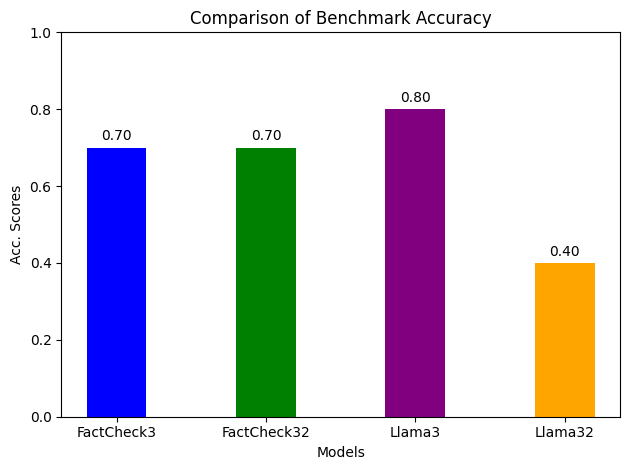

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Benchmark data
models =  [item["name"] for item in modelResults]
acc = [item["acc"] for item in modelResults]
f1 = [item["f1"] for item in modelResults]

# Bar chart parameters
x = np.arange(len(models))  # Position of bars
width = 0.4  # Width of bars

# Create the plot
fig, ax = plt.subplots()
bars = ax.bar(x, acc, width, color=['blue', 'green', 'purple', 'orange'])

# Add labels, title, and custom ticks
ax.set_xlabel('Models')
ax.set_ylabel('Acc. Scores')
ax.set_title('Comparison of Benchmark Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)  # Adjust y-axis range if needed
ax.bar_label(bars, fmt='%.2f', padding=3)  # Add values on top of bars

# Show the chart
plt.tight_layout()
plt.show()

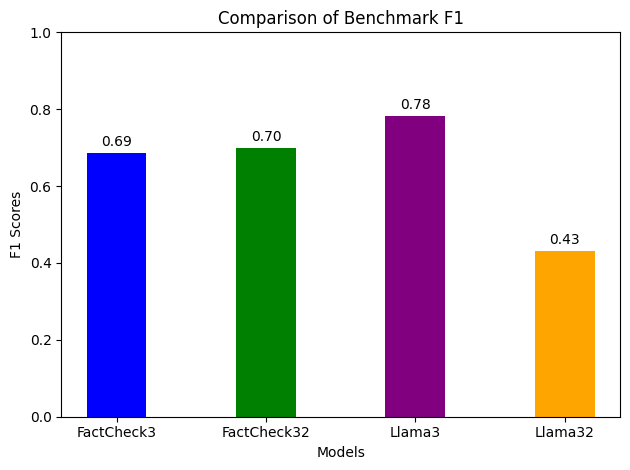

In [7]:
# Bar chart parameters
x = np.arange(len(models))  # Position of bars
width = 0.4  # Width of bars

# Create the plot
fig, ax = plt.subplots()
bars = ax.bar(x, f1, width, color=['blue', 'green', 'purple', 'orange'])

# Add labels, title, and custom ticks
ax.set_xlabel('Models')
ax.set_ylabel('F1 Scores')
ax.set_title('Comparison of Benchmark F1')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)  # Adjust y-axis range if needed
ax.bar_label(bars, fmt='%.2f', padding=3)  # Add values on top of bars

# Show the chart
plt.tight_layout()
plt.show()